# Enigma Data Science Takehome: Notebook 1

### Details:
Section 1: Warm Up (1/4)

1. Which companies applied for the largest number of H­1B visas where the job opening was located in NYC? Please describe any issues you may encounter summarizing the data by employer name.

2. Calculate the mean and standard deviation of wages proposed for workers located in New York City and Mountain View. Are the average wages in these two locations statistically different? What factors could explain the results?

3. For NYC, what is the relationship between the total number of H­1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship?


### Data Source:
Data downloaded as csv from Enigma's Abstract platform here: https://app.enigma.io/table/us.gov.dol.oflc.h1b.2014

In [2]:
#These scripts are running on Python version 2.7.10

import pandas as pd
import numpy as np
from scipy import stats

In [3]:
#ingest data into Pandas Df

#set folder location of data
folder_loc = '/Users/benjaminnichols/Desktop/enigma_data/'

visa_df = pd.read_csv(folder_loc+'h1b_applications_2014.csv')

# Data Prep

In [4]:
#different visa types

list(visa_df['visa_class'].unique())

['H-1B', 'H-1B1 Chile', 'H-1B1 Singapore', 'E-3 Australian']

In [5]:
visa_counts = pd.DataFrame(
        visa_df.groupby('visa_class')['serialid']
        .count()
        .rename(index = str, columns='application_count'))
visa_counts.columns = ['application_count']
visa_counts['PercentOfApps'] = visa_counts['application_count'].apply(lambda x: x*1.0 / visa_counts['application_count'].sum())

#Consider each visa type as a percentage of total visa applications.
visa_counts['PercentOfApps']

visa_class
E-3 Australian     0.018183
H-1B               0.979157
H-1B1 Chile        0.001072
H-1B1 Singapore    0.001588
Name: PercentOfApps, dtype: float64

### Assumption: H-1B visas does not include the following visa types, omitting 2.1% of total applications from further analysis:
    E-3 Australian
    H-1B1 Chile
    H-1B1 Singapore
    
Differences in the E3 visa type can be explored further here:
- https://en.wikipedia.org/wiki/E-3_visa
- https://www.visacoach.org/2010/05/18/e3-visa-difference-to-the-h1b-visa

The differences in the H-1B1 Chile and H-1B1 Singapore can be explored further here:
- https://en.wikipedia.org/wiki/H-1B1_visa

#### Rationale:
The fundamental differences in these visa types may mislead the analysis of H-1B visa related analyses

In [6]:
#create an H-1B specific dataset, removing the other visa types
h1b_df = visa_df[visa_df['visa_class'] == 'H-1B']

In [7]:
#determine if cases are repeated in the dataset

case_srs = h1b_df.groupby('lca_case_number')['serialid'].count()
case_srs[case_srs > 1] #empty series ==> non reapeated cases

Series([], Name: serialid, dtype: int64)

# Section 1

# Q1
##### Which companies applied for the largest number of H­1B visas where the job opening was located in NYC? Please describe any issues you may encounter summarizing the data by employer name.

In [13]:
ny_mask = ((h1b_df['lca_case_employer_city'] == 'NEW YORK') & (h1b_df['lca_case_employer_state'] == 'NY'))

employer_apps = pd.DataFrame(h1b_df[ny_mask]
     .groupby('lca_case_employer_name')['serialid']
     .count()
     ).sort_values('serialid', axis=0, ascending=False)
employer_apps.columns = ['application_count']


### Top 50 NYC-based employers by application count

In [15]:
employer_apps.head(50)

,application_count
lca_case_employer_name,
MPHASIS CORPORATION,944
"GOLDMAN, SACHS & CO.",594
MORGAN STANLEY & CO. LLC,450
"CITIBANK, N.A.",403
"BLOOMBERG, LP",355
CREDIT SUISSE SECURITIES (USA) LLC,334
COLUMBIA UNIVERSITY,303
CITIGROUP GLOBAL MARKETS INC.,270
"AMERICAN EXPRESS TRAVEL RELATED SERVICES COMPANY,",225


##### Caveat:
There are two issues to tackle: (1) quality issues and (2) complexity of the corporate landscape:

(1) The same Employer may be represented multiple times due to differences in spelling, punctuation, or corporate accreditation specification (e.g. including/excluding 'inc')

(2) Subsidiary companies listed as the primary employer if some, but not all visa applications.

In [17]:
#Resolve some of the data formatting issues:

employer_apps_frmt = employer_apps.copy()
employer_apps_frmt = employer_apps_frmt.reset_index()
employer_apps_frmt['lca_case_employer_name'] = employer_apps_frmt['lca_case_employer_name'].map(lambda x: x.replace(',','')
                                                       .replace('.',''))

#group by the new employer names and sum the application counts from the preformatted data

employer_apps_frmt = pd.DataFrame(employer_apps_frmt
                                    .groupby('lca_case_employer_name')['application_count']
                                    .sum()).sort_values('application_count', axis=0, ascending=False)

### Top 50 NYC-based employers by application count (formatted)

In [18]:
employer_apps_frmt.head(50)

,application_count
lca_case_employer_name,
MPHASIS CORPORATION,944
GOLDMAN SACHS & CO,819
MORGAN STANLEY & CO LLC,493
CITIBANK NA,403
BLOOMBERG LP,363
CREDIT SUISSE SECURITIES (USA) LLC,334
COLUMBIA UNIVERSITY,303
CITIGROUP GLOBAL MARKETS INC,270
AMERICAN EXPRESS TRAVEL RELATED SERVICES COMPANY,225


# Q2
Calculate the mean and standard deviation of wages proposed for workers located in New York City and Mountain View. Are the average wages in these two locations statistically different? What factors could explain the results?

In [19]:
#according to abstract, teh wage field 'lca_case_wage_rate_from' is the Employer's proposed wage rate.

nyc_mask = ((h1b_df['lca_case_employer_city'] == 'NEW YORK') & (h1b_df['lca_case_employer_state'] == 'NY'))
moutainview_mask = ((h1b_df['lca_case_employer_city'] == 'MOUNTAIN VIEW') & (h1b_df['lca_case_employer_state'] == 'CA'))
cert_mask = (h1b_df['status'] == 'CERTIFIED')

#NYC
nyc_wages = h1b_df[nyc_mask]['lca_case_wage_rate_from']
nyc_prop_wage_mean = np.mean(nyc_wages)
nyc_prop_wage_std = np.std(nyc_wages)

#Mountain View
mv_wages = h1b_df[moutainview_mask]['lca_case_wage_rate_from']
mv_prop_wage_mean = np.mean(mv_wages)
mv_prop_wage_std = np.std(mv_wages)


In [20]:
print('The mean and standard deviation in proposed wages for H-1B visas in NYC are: '
    +str(nyc_prop_wage_mean)+\
    ', and '\
    +str(nyc_prop_wage_std)+\
     ', respectfully.\n')
print('The mean and standard deviation in proposed wages for H-1B visas in Mountainview are: '
    +str(mv_prop_wage_mean)+\
    ', and '\
    +str(mv_prop_wage_std)+\
     ', respectfully.')

The mean and standard deviation in proposed wages for H-1B visas in NYC are: 84381.6657099381, and 62664.76465201309, respectfully.

The mean and standard deviation in proposed wages for H-1B visas in Mountainview are: 117580.42429095121, and 35271.71802255795, respectfully.


#### For the sake of comparing whether the means of these populations are statistically different, let's assume a 2 tailed t-test at the 95th percent confidence interval.

H0: The average proposed wages are the same in the two locations

H1: The average proposed wages are different in the two locations

#### Outcome
Fail to reject H0 if p-val > 0.05

Reject H0 if p-val < 0.05 and accept H1.

In [21]:
#The methodology for this test needs to estimate the population variance either once or twice,
#but since the standard deviations are not equal, we must estimate them both [equal_var=False]

nyc_wage_list = list(nyc_wages[nyc_wages.notnull()])
mv_wage_list = list(mv_wages[mv_wages.notnull()])

stats.ttest_ind(nyc_wage_list, mv_wage_list, equal_var=False)

Ttest_indResult(statistic=-52.24503065955318, pvalue=0.0)

#### Based on the result of the statistical significance test, we must reject the null hypothesis that the averages are different, and accept the alternative hypothesis that the averages are statistically different.

(p-val = 0.0) < (alpha = 0.05)

#### Explanation of Results

A possible reason why the two proposed H-1B average wages are different comes down to local economics. Consider the similar difference in median income between the two locations in 2015. From the US Census bureau, we see that Mountain View, CA had a median per capita income of \$58,565 while NYC, NY had a median per capita income of $33,078.

The average wage for all employees is higher in Mountain View, therefore it's no surprise that visa employees follow that same trend.

# Q3
For NYC, what is the relationship between the total number of H­1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship

In [22]:
#Recycling the formatted Employer Names without teh '.' or the ','

ny_mask = ((h1b_df['lca_case_employer_city'] == 'NEW YORK') & (h1b_df['lca_case_employer_state'] == 'NY'))

h1b_df['lca_case_employer_name_frmt'] = h1b_df['lca_case_employer_name'].apply(lambda x: str(x).replace(',','').replace('.',''))

nyc_h1b_df = h1b_df[ny_mask]

nyc_apps = pd.DataFrame(nyc_h1b_df.groupby('lca_case_employer_name_frmt')['serialid'].count())
nyc_apps.columns = ['application_count']
nyc_wage = pd.DataFrame(nyc_h1b_df.groupby('lca_case_employer_name_frmt')['lca_case_wage_rate_from'].mean())
nyc_wage.columns = ['mean_wage']

nyc_stats = pd.merge(left = nyc_apps, right = nyc_wage, how = 'inner', left_index=True, right_index=True)

/Users/benjaminnichols/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


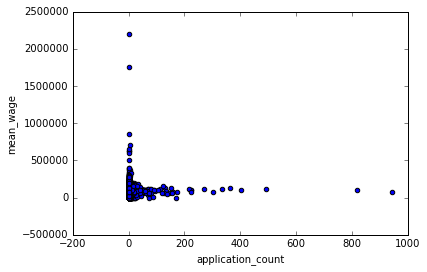

In [23]:
#Generate a scatter plot of # applications vs average wage by employer [1 dot == 1 employer]

%matplotlib inline

nyc_stats.plot(kind='scatter', x='application_count', y = 'mean_wage')

^^NOTE: Appears to model the equation y = (1/x) in the positive plane

In [26]:
# create a function which will bucket values into 5 categories based on the number of applications:

def bucketing(val):
    if val == 1:
        return '1. [1,2)'
    elif val == 2:
        return '2. [2,3)'
    elif val <= 6:
        return '3. [3,7)'
    elif val <= 25:
        return '4. [7,25)'
    else:
        return '5. [26, inf]'       

In [27]:
#Apply the bucketing function and consider bucket distribution by employer counts:

nyc_stats['app_count_bucket'] = nyc_stats['application_count'].apply(lambda x: bucketing(x))
nyc_stats.groupby('app_count_bucket')['application_count'].count()

app_count_bucket
1. [1,2)        3044
2. [2,3)        1098
3. [3,7)         923
4. [7,25)        367
5. [26, inf]     109
Name: application_count, dtype: int64

In [40]:
#Create Boolean masks for each bucket level for plotting purposes

low_mask = nyc_stats['app_count_bucket'] == '1. [1,2)'
low_med_mask = nyc_stats['app_count_bucket'] == '2. [2,3)'
med_mask = nyc_stats['app_count_bucket'] == '3. [3,7)'
med_high_mask = nyc_stats['app_count_bucket'] == '4. [7,25)'
high_mask = nyc_stats['app_count_bucket'] == '5. [26, inf]'

masks = [low_mask, low_med_mask, med_mask, med_high_mask, high_mask]

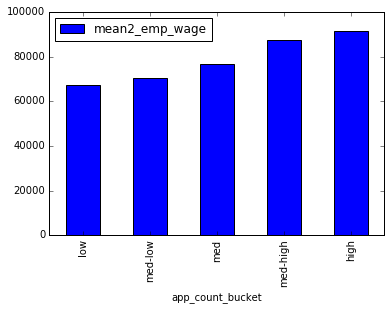

In [42]:
#Let's have a high-level view of mean wage by application size-bucket to eyeball any relationships

means_by_bucket = list(map(lambda x: np.mean(nyc_stats[x]['mean_wage']), masks))
means_by_bucket_df = pd.DataFrame(list(zip(['low','med-low','med','med-high','high'],means_by_bucket)), columns=['app_count_bucket','mean2_emp_wage'])
means_by_bucket_df.set_index('app_count_bucket').plot(kind='bar')

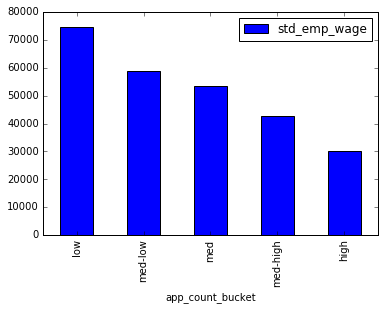

In [44]:
#Let's consider each bucket's standard deviation to determine if we are considering similar population distributions

std_by_bucket = list(map(lambda x: np.std(nyc_stats[x]['mean_wage']), masks))
std_by_bucket_df = pd.DataFrame(list(zip(['low','med-low','med','med-high','high'],std_by_bucket)), columns=['app_count_bucket','std_emp_wage'])
std_by_bucket_df.set_index('app_count_bucket').plot(kind='bar')

#### At a glance it seems as though there is a difference in the mean employer wage vs the number of applications. As the number of applications go up, so does the avg_wage.

#### An ANOVA test would be appropriate to analyze the difference in the means, however the property known as homoscedasticity (i.e. same standard deviation for each comparison group) is not met (as seen in the plot of the bucket standard deviation) preventing us from going any further at this time.

In [50]:
#Do not use stat-test as homoskedacity constraint is not met
#stats.f_oneway(low_wage, low_med_wage, med_wage, med_high_wage, high_wage)

#### What might explain the relationship that the greater the number of H-1B applications an employer has, the higher the average proposed wage is for the position?

(1) H-1B visa applications are an expensive endeavor for employer, however if an employer is able to juggle more and more applications, there is likely an economies of scale effect where the incremental cost is lower through operational efficiency. This savings could then allow a competitive advantage for the employer by offering a higher wage to the visa applicant from the operational dollars saved.

(2) There may also be a lurking correlation between the average wage of all employees at companies at each application size-bucket. In other words, companies that have the most applications for H-1B visas might also have the highest average wage for all employees, and vice versa - similar to what we saw with respect to the comparison between NYC and Mountain View median per capita income.